![](images/person-holds-a-basket-full-of-groceries-in-a-supermarket.jpg)

In this project I used the K-means algorithm to cluster grocery items based on their transaction data.

**Items that are often purchases together can be placed in the same aisle or aisles closer to each other,
increasing sales!**

This used to be done by human experts, which would require **many years of experience** in the industry to
narrow things down. However, with the rise of big data and machine learning, why not
let AI do all the trick and hard work for you?

Ok let's get started. The first step is to gather the dataset. Here I downloaded
[the Instacart dataset](https://www.kaggle.com/c/instacart-market-basket-analysis/data)
from Kaggle, and **filtered out items that don't have a sufficient purchase history** yet in the dataset
(being purchased fewer than 100 times), because they may not contain enough information to be correctly
classified(i.e. they may end up forming weird 1-item categories).

In [1]:
# Load dependencies
import pandas as pd
from scipy import sparse
from sklearn import metrics
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

from utility.jupyter import hide_toggle
pd.set_option('display.max_rows', 30)

# Load the Instacart data and cluster items that have been purchased at least 100 times
df = pd.read_csv('data/order_products__train.csv')
df = df.drop(['add_to_cart_order', 'reordered'], axis=1)
df = df.groupby('product_id').filter(lambda x:len(x) >= 100)

df_products = pd.read_csv('data/products.csv')
df_aisles = pd.read_csv('data/aisles.csv')

hide_toggle()

The main table is pretty straightforward, classical order_id - product_id pairs.

In [4]:
df.head()

,order_id,product_id
1,1,11109
2,1,10246
3,1,49683
5,1,13176
6,1,47209


Now let's transform the order data into a matrix where:
- each row is an order
- each column is a product
- each value 1 indicates a purchase

In [5]:
df['filler'] = 1
df = df.pivot(index='order_id', columns='product_id', values='filler').fillna(0)

hide_toggle()

In [6]:
df.head()

product_id,10,34,45,79,95,116,117,130,141,160,...,49481,49517,49520,49533,49585,49605,49610,49621,49628,49683
order_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
36,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
38,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
98,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
print('Number of Transactions:', df.shape[0])
print('Number of Items:', df.shape[1])

Number of Transactions: 125956
Number of Items: 2457


Cool, now that everything has been set up, let's transform the data into a **similarity matrix**.
(here I used the cosine similarity, but other metrics should be fine).

Essentially, items that are often purchased together will have a similarity of 1, whereas
those that have never been purchased together will have a similarity of 0.

In [10]:
# Save memories by converting it to a sparse matrix
data = df.to_numpy()
data_sparse = sparse.csr_matrix(data)
data_clustering = metrics.pairwise.cosine_similarity(data_sparse.T)
data_clustering = sparse.csr_matrix(data_clustering)

hide_toggle()

Then, time to apply the K-means algorithm using the similarity matrix we just obtained!

How do we choose K though? It's usually more subject to the business requirements.
However, here what we can do is to pick a bunch of Ks and look at the inertia plot.
A range between 8 and 20 would probably be a good start since we don't want to make things too complicated.

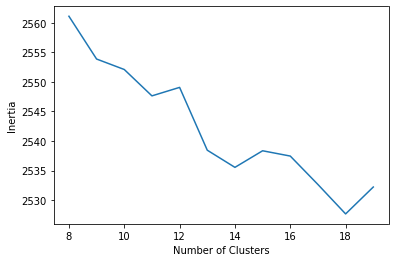

In [15]:
cluster_inertia = []
for i in range(8, 20):
    model = KMeans(n_clusters=i)
    model.fit(data_clustering)
    cluster_inertia.append(model.inertia_)

plt.plot(range(8, 20), cluster_inertia)
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

hide_toggle()


According to the plot, 14 seems to be a good choice, since the gains seem to be pretty low as K increases.
Let's now plug in k=14 and get our clusters!

In [17]:
kmeans = KMeans(n_clusters=14)

clusters = kmeans.fit_predict(data_clustering)
final_clusters = pd.DataFrame({'cluster':clusters,
                               'product_id':df.columns})
df_cluster = final_clusters.sort_values('cluster')
df_cluster = pd.merge(df_cluster, df_products, how='left', on='product_id')

hide_toggle()

In [18]:
df_cluster

,cluster,product_id,product_name,aisle_id,department_id
0,0,31562,Sweet Onions,83,4
1,0,41463,Cannellini Beans,59,15
2,0,41544,Organic Crushed Fire Roasted Tomatoes,81,15
3,0,28156,Total 0% Nonfat Plain Greek Yogurt,120,16
4,0,7746,Oregano,104,13
...,...,...,...,...,...
2452,13,15261,Organic Rosemary,16,4
2453,13,12409,Organic Distilled White Vinegar,19,13
2454,13,25659,Organic Coconut Milk,91,16
2455,13,5479,Italian Sparkling Mineral Water,115,7


Get some basic stats regarding our clusters.

In [19]:
df_cluster['cluster'].value_counts()

8     404
3     379
4     337
11    244
0     187
13    170
6     147
12    133
7     127
2     126
1     121
5      63
9      10
10      9
Name: cluster, dtype: int64

The group counts seem quite reasonable. Let's inspect some of the categories manually!

In [25]:
df_cluster.query('cluster == 0').head(20)

,cluster,product_id,product_name,aisle_id,department_id
0,0,31562,Sweet Onions,83,4
1,0,41463,Cannellini Beans,59,15
2,0,41544,Organic Crushed Fire Roasted Tomatoes,81,15
3,0,28156,Total 0% Nonfat Plain Greek Yogurt,120,16
4,0,7746,Oregano,104,13
5,0,20549,Organic Orzo,131,9
6,0,20520,Mild Diced Green Chiles,81,15
7,0,41588,Firm Tofu,14,20
8,0,41610,Arborio White Rice,63,9
9,0,7628,"Dressing, Jersey Sweet Onion, Calorie Free",83,4


In [29]:
df_cluster.query('cluster == 1').head(20)

,cluster,product_id,product_name,aisle_id,department_id
187,1,31040,Sea Salt Pita Chips,107,19
188,1,43504,Organic Chicken Strips,34,1
189,1,43713,Organic Creamy Peanut Butter,88,13
190,1,31433,Organic Cinnamon Crunch Cereal,121,14
191,1,11777,Red Raspberries,123,4
192,1,18523,Total 2% All Natural Greek Strained Yogurt wit...,120,16
193,1,43352,Raspberries,32,4
194,1,43295,Unsweetened Vanilla Almond Milk,91,16
195,1,18370,Organic Shredded Mozzarella,21,16
196,1,18465,Organic Grade A Free Range Large Brown Eggs,86,16


In [35]:
df_cluster.query('cluster == 5').head(20)

,cluster,product_id,product_name,aisle_id,department_id
1150,5,45066,Honeycrisp Apple,24,4
1151,5,47209,Organic Hass Avocado,24,4
1152,5,45007,Organic Zucchini,83,4
1153,5,26604,Organic Blackberries,24,4
1154,5,44359,Organic Small Bunch Celery,83,4
1155,5,46979,Asparagus,83,4
1156,5,24184,Red Peppers,83,4
1157,5,28985,Michigan Organic Kale,83,4
1158,5,40706,Organic Grape Tomatoes,123,4
1159,5,40604,Feta Cheese Crumbles,21,16


In [31]:
df_cluster.query('cluster == 9')

,cluster,product_id,product_name,aisle_id,department_id
1891,9,36865,Non Fat Raspberry Yogurt,120,16
1892,9,13263,Non Fat Acai & Mixed Berries Yogurt,120,16
1893,9,8309,Nonfat Icelandic Style Strawberry Yogurt,120,16
1894,9,26131,Mixed Berries Whole Milk Icelandic Style Skyr ...,120,16
1895,9,11448,Strained Non Fat Orange & Ginger Yogurt,120,16
1896,9,24799,Vanilla Skyr Nonfat Yogurt,120,16
1897,9,8490,Strawberry Rhubarb Yogurt,120,16
1898,9,28465,Icelandic Style Skyr Blueberry Non-fat Yogurt,120,16
1899,9,43662,"Yogurt, Strained Low-Fat, Coconut",120,16
1900,9,30563,Strained Non-Fat Strawberry Icelandic Style Sk...,100,21


In [32]:
df_cluster.query('cluster == 10')

,cluster,product_id,product_name,aisle_id,department_id
1901,10,42372,Pineapple on the Bottom Greek Yogurt,120,16
1902,10,33791,Raspberry on the Bottom Nonfat Greek Yogurt,120,16
1903,10,48626,Coconut Blended Greek Yogurt,120,16
1904,10,44156,Strawberry on the Bottom Nonfat Greek Yogurt,120,16
1905,10,33548,Peach on the Bottom Nonfat Greek Yogurt,120,16
1906,10,7533,Low-Fat Strawberry Banana on the Bottom Greek ...,120,16
1907,10,38241,Low-Fat Mango on the Bottom Greek Yogurt,120,16
1908,10,46817,Non Fat Black Cherry on the Bottom Greek Yogurt,120,16
1909,10,23296,Blueberry on the Bottom Nonfat Greek Yogurt,120,16


Voila! A few interesting discoveries here:
- Category 0 seems to be raw cooking materials!
- Category 1 seems to be organic products and snacks!
- Category 5 seems to be organic products as well!(But they don't seem to be bought together with snacks)
- Category 9 and 100 seem to be two clusters of low/non-fat dairy products.

